In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from time import time

Open file

In [32]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

Sample the data (can be removed completely later)

In [33]:
df = df.drop(df.columns[0], axis=1) # We are dropping the first coolumn because it is just an index
df = df.sample(n=10000, random_state=42)

Remove null values for start_station_id and end_station_id

In [34]:
df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 16303534 to 4635301
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9999 non-null   int64  
 1   starttime                9999 non-null   object 
 2   stoptime                 9999 non-null   object 
 3   start_station_id         9999 non-null   float64
 4   start_station_latitude   9999 non-null   float64
 5   start_station_longitude  9999 non-null   float64
 6   end_station_id           9999 non-null   float64
 7   end_station_latitude     9999 non-null   float64
 8   end_station_longitude    9999 non-null   float64
 9   bikeid                   9999 non-null   int64  
 10  usertype                 9999 non-null   object 
 11  birth_year               9999 non-null   int64  
 12  gender                   9999 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.1+ MB


Clean up the data

In [35]:
# Convert start_time and end_time columns to datetime format
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Extract date, hour, and day of the week from start_time column
df['date'] = df['starttime'].dt.date
df['hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek

# Drop any rows with null values
df = df.dropna()

# Drop any rows with negative trip durations
df = df[df['tripduration'] > 0]

# Drop any rows with trip durations greater than 24 hours
df = df[df['tripduration'] <= 86400]

# Drop rows that are outside the 99th percentile of trip durations
df = df[df['tripduration'] <= df['tripduration'].quantile(.99)]

# Drop rows where the birth_year is outside the lower 99th percentile of birth years
df = df[df['birth_year'] >= df['birth_year'].quantile(.01)]

# Drop rows where the gender is not 0, 1
df = df[df['gender'].isin([0, 1])]

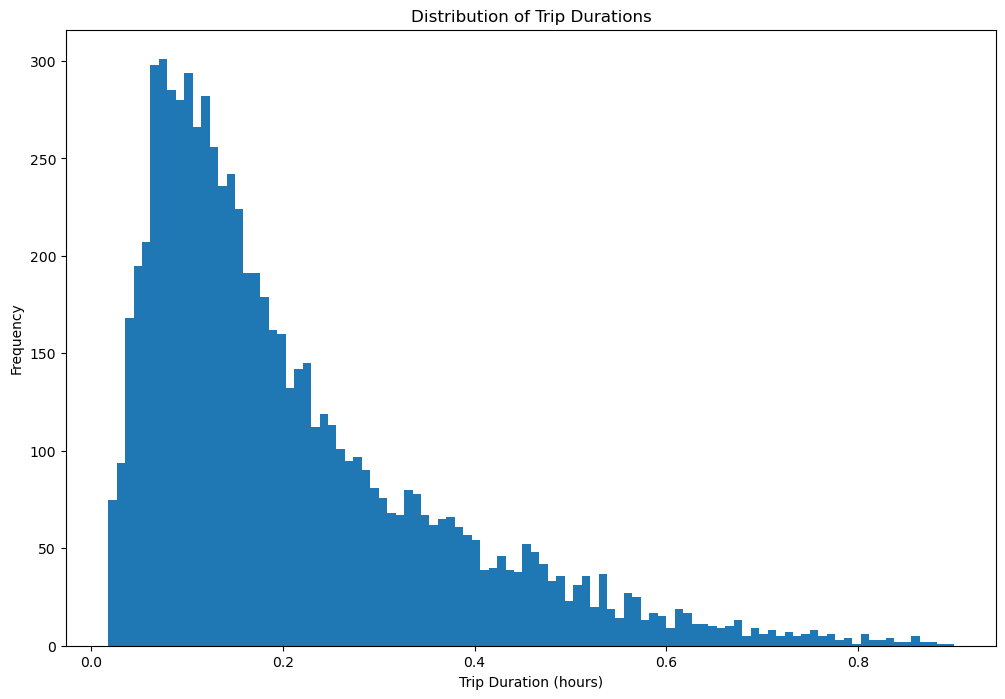

In [36]:
# Distribution of trip durations
plt.figure(figsize=(12, 8))
plt.hist(df['tripduration']/3600, bins=100)
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations')
plt.savefig(os.path.join('plots', 'trip_duration_distribution.png'))
plt.show()


PCA on the data

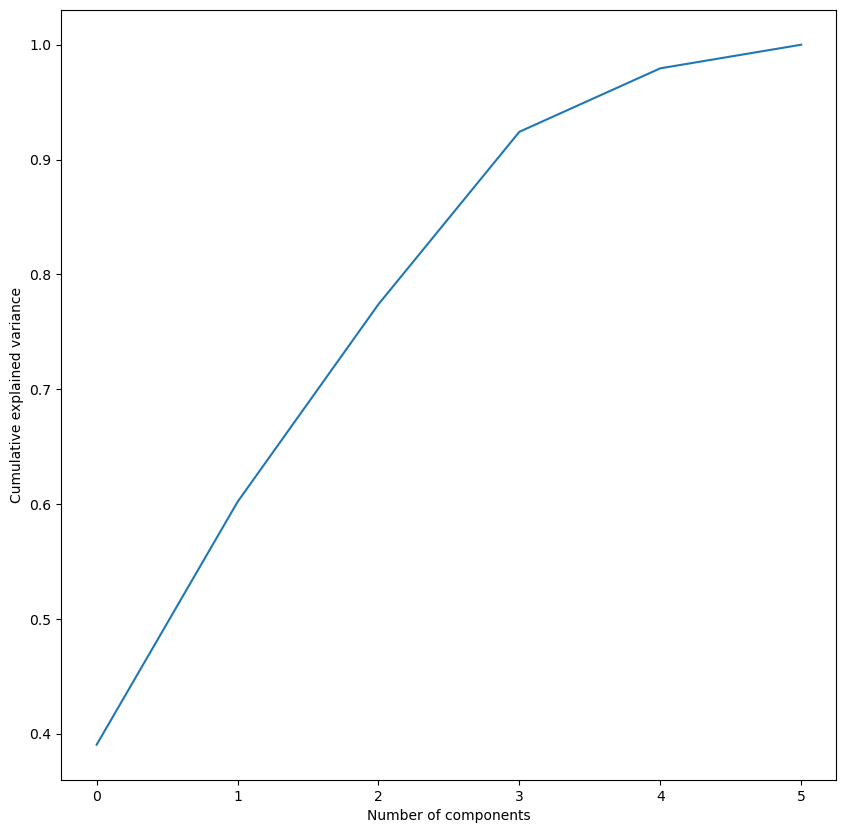


Principal Component 1 Loadings:
end_station_latitude       0.533767
start_station_latitude     0.528324
end_station_longitude      0.469939
start_station_longitude    0.463621
tripduration               0.013092
birth_year                 0.002909
Name: 0, dtype: float64

Principal Component 2 Loadings:
start_station_longitude    0.460149
end_station_longitude      0.452938
birth_year                 0.425111
tripduration              -0.290057
end_station_latitude      -0.394430
start_station_latitude    -0.403339
Name: 1, dtype: float64

Principal Component 3 Loadings:
tripduration               0.717283
start_station_longitude    0.260651
end_station_longitude      0.251144
end_station_latitude      -0.230457
start_station_latitude    -0.234329
birth_year                -0.496461
Name: 2, dtype: float64

Principal Component 4 Loadings:
birth_year                 0.756777
tripduration               0.633358
start_station_latitude     0.078271
end_station_latitude       0.060754
end_

In [37]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration']])
scaled_df = pd.DataFrame(scaled_df, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])

# PCA using all the features
pca = PCA(n_components=6)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
pca_df = pd.DataFrame(pca.components_, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])


plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig(os.path.join('plots', 'pca_cumulative_explained_variance.png'))
plt.show()

corr_matrix = scaled_df.corr()
corr_matrix['tripduration'].sort_values(ascending=False)

# Print the loadings for each principal component
for i in range(len(pca_df)):
    print(f"\nPrincipal Component {i + 1} Loadings:")
    print(pca_df.iloc[i].sort_values(ascending=False))


Elbow method

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda

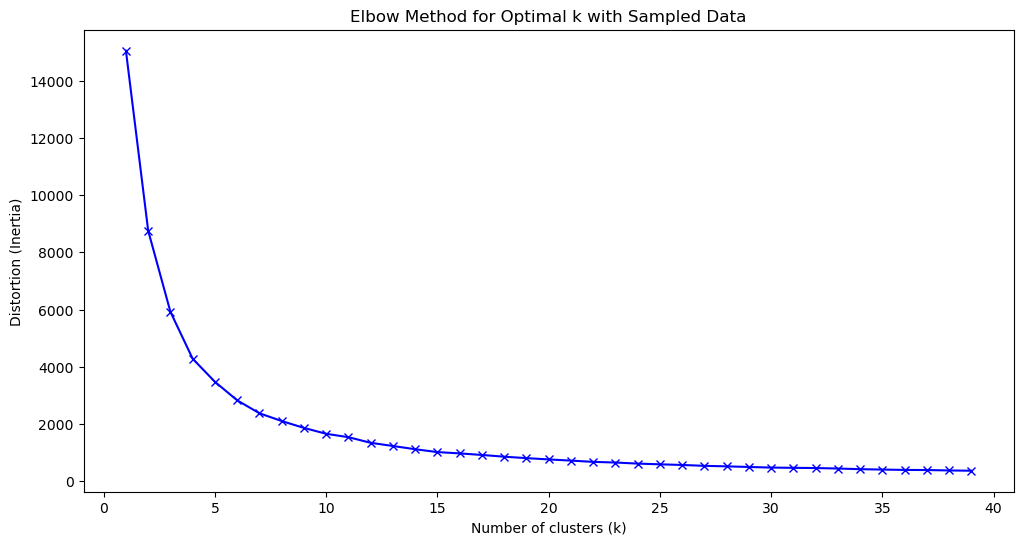

In [38]:
# Extract coordinates from the sample
coordinates_sample = df[['start_station_latitude', 'start_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
# coordinates_sample = coordinates_standardized

#Elbow method
distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


Further processing with K-means clustering to remove locations we don't care about

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

# Extract coordinates from the sample
coordinates_start = df[['start_station_latitude', 'start_station_longitude']]
coordinates_end = df[['end_station_latitude', 'end_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_start)

# Plot K-means with 20 clusters
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(coordinates_standardized)
df['cluster'] = kmeans.predict(coordinates_standardized)

# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(coordinates_start)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.predict(coordinates_start)

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Plot the clusters on a map

In [40]:
import plotly.express as px

def plot_stations_map(stations):
    #First before plotting we have to deal with the outliers 
    #The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

    lon_min = -79.76259
    lat_min = 40.4774
    lon_max = -71.18507
    lat_max = 45.01585

    # Store the stations that are within the boundaries
    stations = stations[
        (stations['start_station_latitude'] > lat_min) &
        (stations['start_station_latitude'] < lat_max) &
        (stations['start_station_longitude'] > lon_min) &
        (stations['start_station_longitude'] < lon_max)
    ]
    
    #Plot the stations with an underlying map of New York City
    title = 'Citi Bike Stations in New York City'
    fig = px.scatter_mapbox(
        stations,
        lat='start_station_latitude',
        lon='start_station_longitude',
        color='cluster',
        mapbox_style='carto-positron',
        zoom=9,
        width=1000,
        height=600
    )
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  # Center the title horizontally
            xanchor='center',  # Anchor point for horizontal alignment
            font=dict(size=20)
        )
    )
    fig.show()


Remove the locations that are more than 3 standard deviations from the center of the clusters

In [41]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(coordinates_start)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

threshold = 2*np.std(distance,axis=1)

# Get the indices of the points that are within the threshold distance of a cluster center
within_threshold = np.argwhere(min_distance < threshold).flatten()

# Remove the points that are outside the threshold distance of a cluster center
df = df.iloc[within_threshold]

# Plot the stations with an underlying map of New York City.
plot_stations_map(df.sample(random_state=42))

Find the most important cluster and get all the relevant values from the dataframe based on it (MVC - Most Valuable Cluster)

In [42]:
# Sort the clusters by the number of trips (instances) in each cluster 
sorted_clusters= df['cluster'].value_counts().idxmax()

# Get the indices of the points that are in the most important cluster
most_important_cluster_indices = np.argwhere(df['cluster'] == sorted_clusters).flatten()

# Get the most important cluster's features
MVC = df.iloc[most_important_cluster_indices].copy()
MVC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 10376436 to 14863760
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             707 non-null    int64         
 1   starttime                707 non-null    datetime64[ns]
 2   stoptime                 707 non-null    datetime64[ns]
 3   start_station_id         707 non-null    float64       
 4   start_station_latitude   707 non-null    float64       
 5   start_station_longitude  707 non-null    float64       
 6   end_station_id           707 non-null    float64       
 7   end_station_latitude     707 non-null    float64       
 8   end_station_longitude    707 non-null    float64       
 9   bikeid                   707 non-null    int64         
 10  usertype                 707 non-null    object        
 11  birth_year               707 non-null    int64         
 12  gender                   707 

Linear Regression model for predicting the trip duration

In [43]:
from sklearn.preprocessing import StandardScaler

# Extract the features
features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Use the most important cluster's features to fit a Linear Regression (LR) model
from sklearn.linear_model import LinearRegression

# Extract the target variable
target = MVC['tripduration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Fit a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

error = y_test - y_pred

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 437.00872839233654


Plot the Linear Regression model results

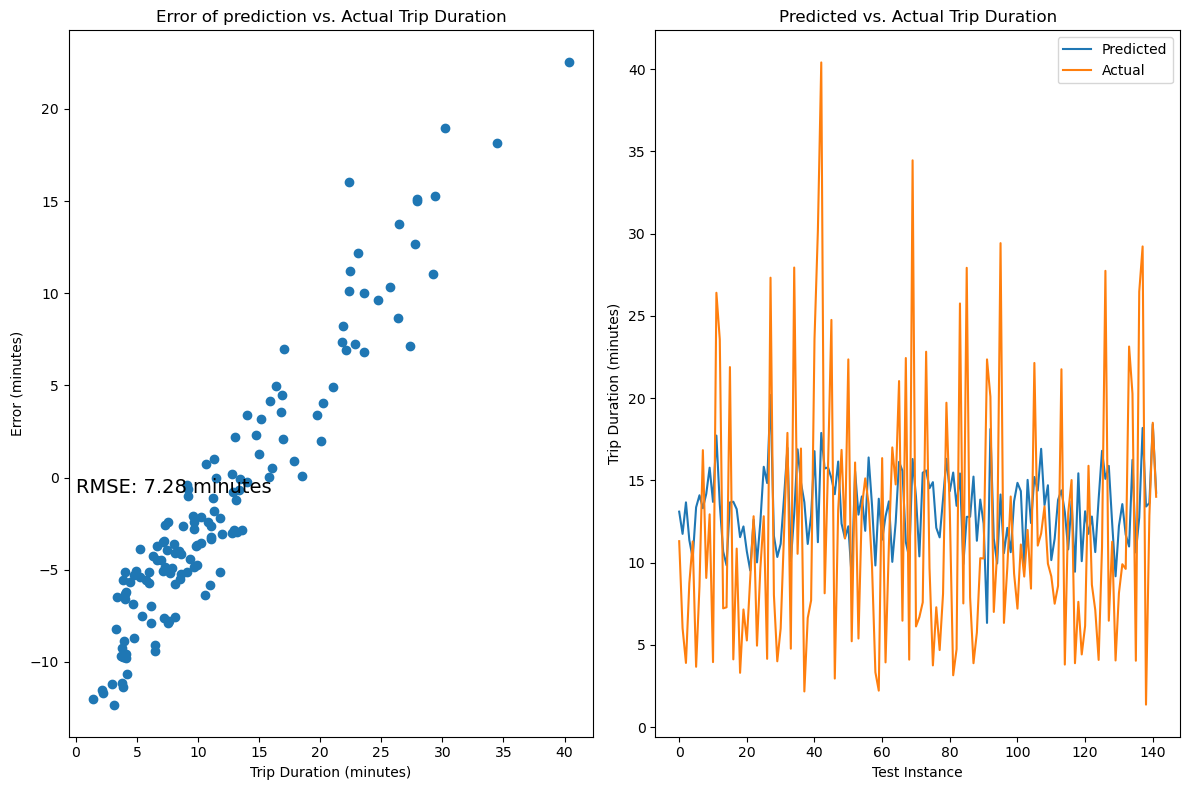

In [44]:
# Plot the error
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots', 'linear_regression.png'))
plt.show()

Random Forest model for predicting the trip duration

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 277.68948435898955


Print the Random Forest model results

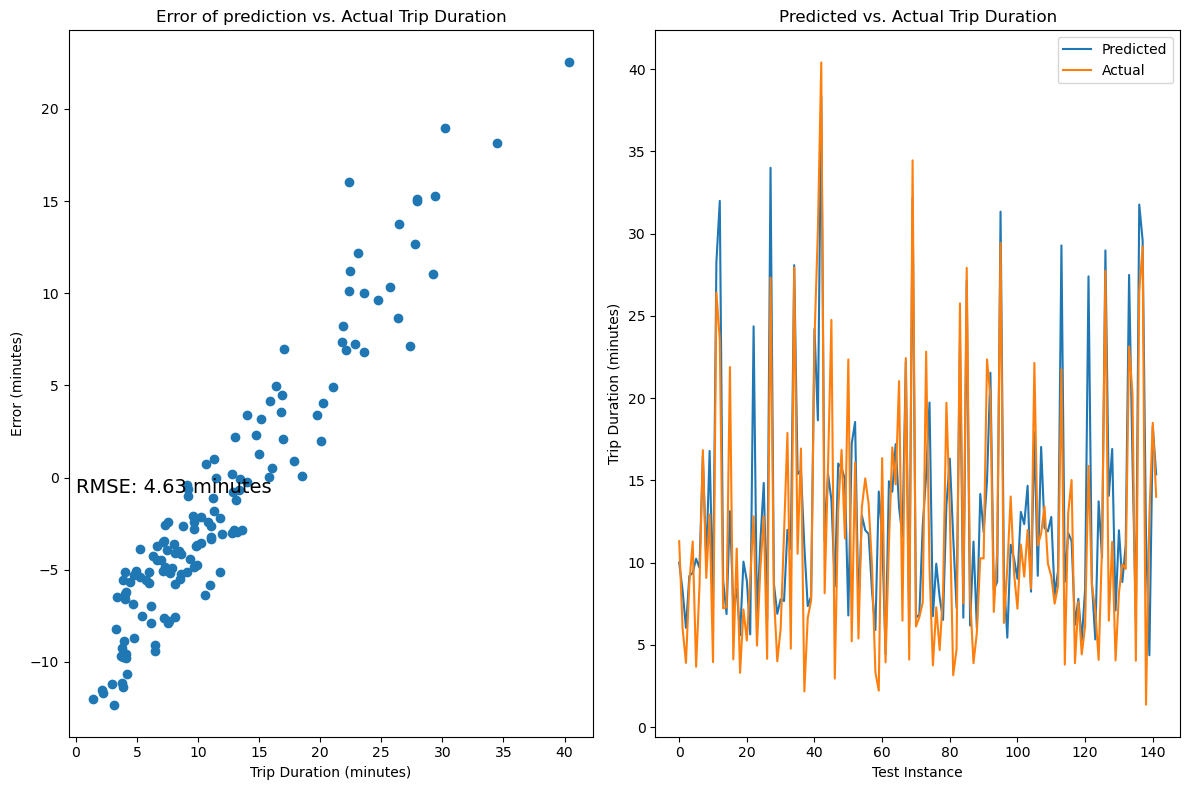

In [46]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots', 'random_forest.png'))
plt.show()


Elli's LSTM model for predicting the trip duration

In [49]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

features_tensor = torch.tensor(features_standardized, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)
# Check if there is a GPU available else run in CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the sequence length
sequence_length = 5  # This is a hyperparameter you can tune

# Reshape the data into sequences
def create_sequences(input_data, target_data, seq_length):
    sequences = []
    target_sequences = []
    for i in range(len(input_data) - seq_length):
        seq = input_data[i:i+seq_length]
        target_seq = target_data[i+seq_length]
        sequences.append(seq)
        target_sequences.append(target_seq)
    return torch.stack(sequences), torch.stack(target_sequences)

X_sequences, y_sequences = create_sequences(features_tensor, target_tensor, sequence_length)

# Split the data into training and test sets
train_size = int(0.8 * len(X_sequences))
X_train_seq = X_sequences[:train_size]
y_train_seq = y_sequences[:train_size]
X_test_seq = X_sequences[train_size:]
y_test_seq = y_sequences[train_size:]

# Create DataLoader instances
batch_size = 64  # Another hyperparameter you can tune
train_dataset = TensorDataset(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(X_test_seq, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, batch_size, hidden_layer_size),
                            torch.zeros(1, batch_size, hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), batch_size, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Initialize the model, loss function, and optimizer
input_size = X_train_seq.shape[2]  # Number of features
hidden_layer_size = 50  # Number of features in hidden state
output_size = 1  # Number of output classes

model = LSTMModel(input_size, hidden_layer_size, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10  # Number of epochs (you might need more)

start_time = time()
y_pred = []
y_true = []
single_losses = []
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, batch_size, model.hidden_layer_size),
                             torch.zeros(1, batch_size, model.hidden_layer_size))
        
        y_pred = model(X_batch)
        single_loss = loss_function(y_pred, y_batch)
        single_loss.backward()
        optimizer.step()
        # Plotting the error
        y_pred.extend(y_pred)
        y_true.extend(y_batch)
        single_losses.append(single_loss.item())

    # Output progress
    if epoch % 1 == 0:
        print(f'Epoch {epoch} loss: {single_loss.item()}')
        remaining_time = (time() - start_time) * (epochs - epoch) / (epoch + 1)
        print(f'Estimated remaining time: {remaining_time/60:.2f} minutes')


# Plot the error and the loss function for each epoch
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (seconds)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(single_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss vs. Batch')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'lstm.png'))
plt.show()


# After training, you might want to save your model
torch.save(model.state_dict(), 'lstm_model.pth')

RuntimeError: shape '[64, 64, -1]' is invalid for input of size 1600

Implement Linear tranformation in a neural network

Epoch [10/3000], Loss: 901220.3125
Estimated remaining time: 0.19 minutes
Epoch [20/3000], Loss: 899751.3750
Estimated remaining time: 0.13 minutes
Epoch [30/3000], Loss: 897451.0000
Estimated remaining time: 0.11 minutes
Epoch [40/3000], Loss: 894108.3750
Estimated remaining time: 0.09 minutes
Epoch [50/3000], Loss: 889382.6250
Estimated remaining time: 0.09 minutes
Epoch [60/3000], Loss: 882899.2500
Estimated remaining time: 0.09 minutes
Epoch [70/3000], Loss: 874254.6250
Estimated remaining time: 0.08 minutes
Epoch [80/3000], Loss: 863026.8125
Estimated remaining time: 0.08 minutes
Epoch [90/3000], Loss: 848777.3125
Estimated remaining time: 0.08 minutes
Epoch [100/3000], Loss: 831067.3750
Estimated remaining time: 0.08 minutes
Epoch [110/3000], Loss: 809511.6875
Estimated remaining time: 0.07 minutes
Epoch [120/3000], Loss: 783804.6250
Estimated remaining time: 0.07 minutes
Epoch [130/3000], Loss: 753821.8750
Estimated remaining time: 0.07 minutes
Epoch [140/3000], Loss: 719591.687

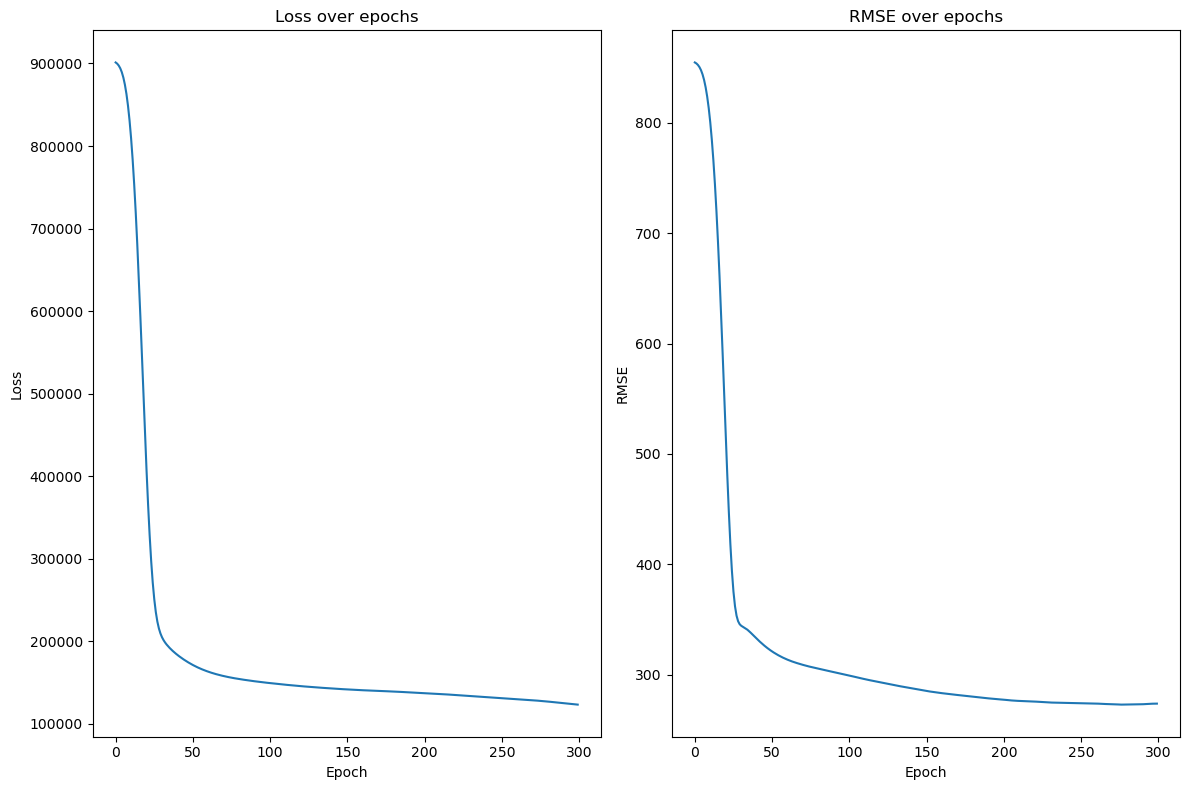

In [ ]:
# Extract the features
features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Extract the target variable
target = MVC['tripduration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Check if there is a GPU available else run in CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Neural Network model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
model = RegressionModel(input_size=X_train.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):    
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn

# Training the model
epochs = 3000 # Number of epochs
losses = [] # Keep track of the losses over time
rmse_array = []
start_time = time()
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())
        rmse_nn = evaluate(model, X_test_tensor, y_test_tensor)
        rmse_array.append(rmse_nn.item())
        # Estimate the remaining time
        remaining_time = (time() - start_time) * (epochs - epoch) / (epoch + 1)
        print(f'Estimated remaining time: {remaining_time/60:.2f} minutes')

# Plot the loss over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1,2,2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'neural_network.png'))
plt.show()



In [ ]:
min_rmse = np.min(rmse_array)
print('Minimum possible RMSE:', min_rmse)

Minimum possible RMSE: 272.9368896484375


Create a NN with dropout layers

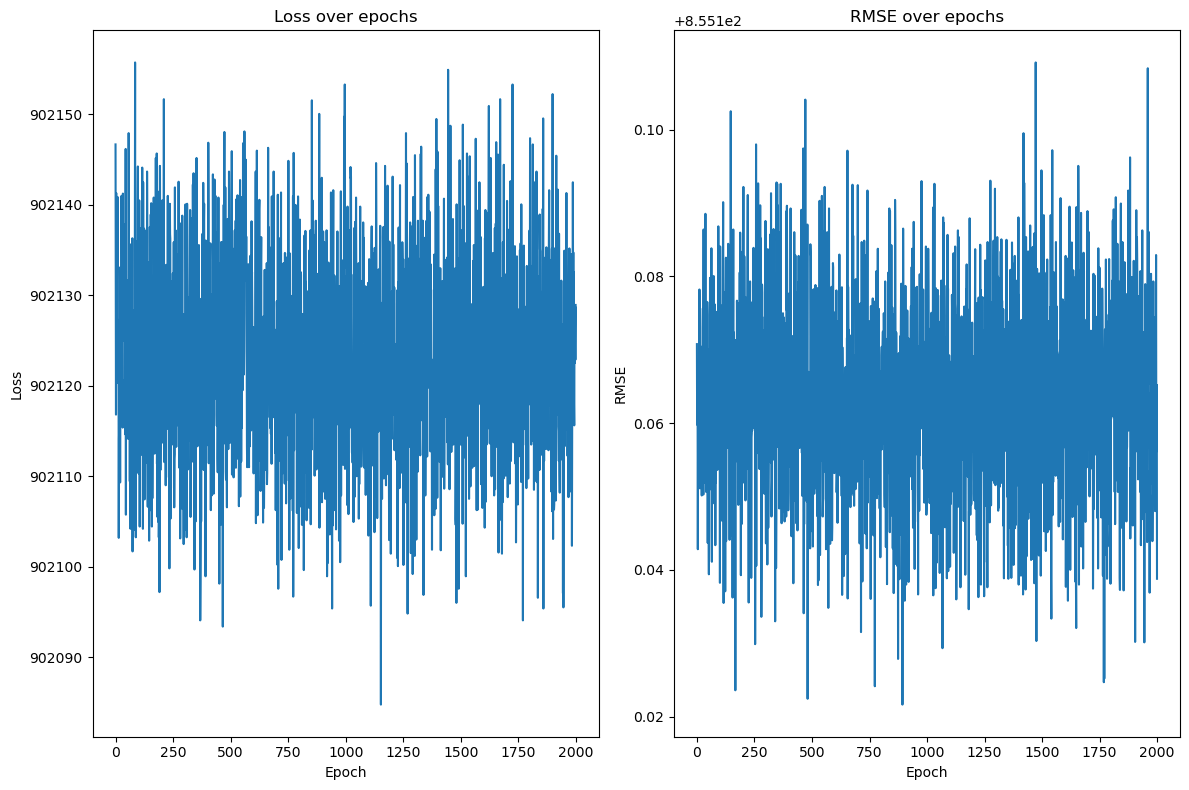

In [ ]:
# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Neural Network model with dropout
class EnhancedRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn

# Training the model
epochs = 20000
losses = []  # Keep track of the losses over time
rmse_array = []

model = EnhancedRegressionModel(input_size=X_train.shape[1])

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        losses.append(loss.item())
        rmse_nn = evaluate(model, X_test_tensor, y_test_tensor)
        rmse_array.append(rmse_nn.item())

# Plot the loss over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'neural_network_dropout.png'))
plt.show()
